<a href="https://colab.research.google.com/github/nklsKrmnn/LSC_Sentiment_Analysis/blob/main/Projekt_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/LSC_Sentiment_Analysis'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/LSC_Sentiment_Analysis


In [ ]:
import numpy as np
import seaborn as sns

try:
  import json
except:
  %pip install -q json
  import json

try:
  import logging
except:
  %pip install -q logging
  import logging

try:
  import sys
except:
  %pip install -q sys
  import sys

try:
  import os
except:
  %pip install -q os
  import os

try:
  import pandas as pd
except:
  %pip install -q pandas
  import pandas as pd

try:
  import torch
  from torch.utils.data import DataLoader
  import torch.nn as nn
  import torch.optim as optim
  from torchsummary import summary
except:
  %pip install -q torch
  import torch
  from torch.utils.data import DataLoader
  import torch.nn as nn
  import torch.optim as optim
  from torchsummary import summary

try:
  from sklearn.model_selection import train_test_split
except:
  %pip install -q sklearn
  from sklearn.model_selection import train_test_split

try:
  import transformers
  from transformers import BertTokenizer, BertModel, BertConfig
except:
  %pip install -q transformers
  import transformers
from transformers import BertTokenizer, BertModel, BertConfig


# 1. Pre-trained BERT Model

## 1.1 Erster Versuch: Training aller Parameter

- Training 2 -> 1 Layer
- Training höhere Dropout-Quote
- Layernorm
- Batchnorm
- Reslayer


In [ ]:
from models.bert import BERTClass

In [ ]:
#model = BERTClass()
model = torch.load("./runs/model_saves/best_model_BERT_2FC_SM--bs50--lr0003--mom5-sge.pt")
print(model)


FileNotFoundError: ignored

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params}")
print(f"Number of parameters: {trainable_params}")

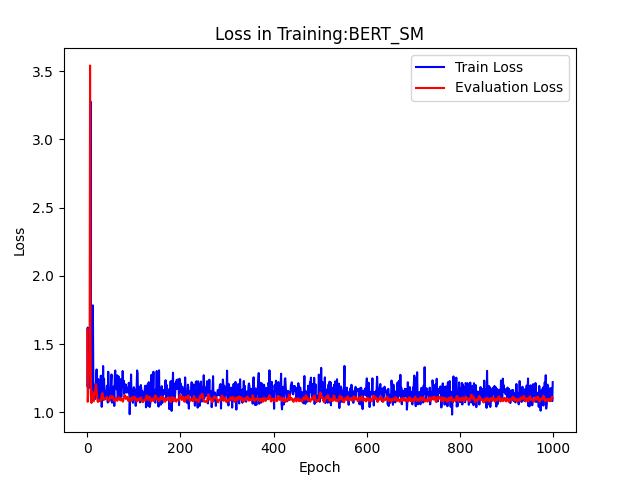

# 1.2 Preprocessing BERT Layer

In [ ]:
from models.bert_without_mlp import BERTClass_without_mlp
from torch import cuda
from data.datasets import dataset as dataset
from torch.utils.data import DataLoader

In [ ]:
def preprocess_first_layer(path_sets, file_path):
  with torch.no_grad():
    device = 'cuda' if cuda.is_available() else 'cpu'

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BERTClass_without_mlp()
    model.to(device)

    path = os.path.join(path_sets, file_path)
    data = pd.read_csv(path, delimiter=";")
    data = data.reset_index(drop=True)

    dataset_params = {
            'onehot': True,
            'tokenize_bert': True,
            'max_len': 200,
            'tokenizer': tokenizer
        }

    dataset_tmp = dataset(data["Phrase"], data["Sentiment"], **dataset_params)


    # Dataloader initialisieren mit Datasets
    loader = DataLoader(dataset_tmp, batch_size=1)

    outputs_bert = []
    for _, batchdata in enumerate(loader):
      outputs_bert.append(model(batchdata, device).tolist()[0])

    outputs_bert = np.array(outputs_bert)
    dataset_after_first_layer = dataset(outputs_bert,
            data["Sentiment"],
            tokenize_bert=False,
            onehot=True,
            second_layer=True)
    dataset_after_first_layer[3]

    return dataset_after_first_layer

In [ ]:
path_sets = "./data/datasets_mr"
train_file = "Trainset_complete.csv"

dataset_after_first_layer = preprocess_first_layer(path_sets, train_file)
new_path = "data/dataset_mr_after_first_layer/" + "dataset_after_first_layer" + train_file.split('.')[0] + ".pt"
torch.save(dataset_after_first_layer, new_path)
print(train_file.split('.')[0] + " saved")


In [ ]:
path_sets = "./data/datasets_mr"
train_file = "Trainset_complete.csv"
val_file = "Validationset.csv"

for ds in os.listdir(path_sets):
  if ("complete" not in ds):
    dataset_after_first_layer = preprocess_first_layer(path_sets, ds)
    new_path = "data/dataset_mr_after_first_layer/" + "dataset_after_first_layer" + ds.split('.')[0] + ".pt"
    torch.save(dataset_after_first_layer, new_path)
    print(ds.split('.')[0] + " saved")


In [ ]:
try:
  import umap
except:
  %pip install umap-learn
  import umap

from sklearn.decomposition import PCA


In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

ds = torch.load("data/dataset_mr_after_first_layer/dataset_after_first_layerTestset.pt")

# Daten für UMAP extrahieren
input_data = [item['input'].tolist() for item in ds]
targets_data = [item['targets'] for item in ds]

# UMAP anwenden
#reducer = umap.UMAP(n_components=3, metric="manhattan")
#scaled_input_data = StandardScaler().fit_transform(input_data)
#embedding = reducer.fit_transform(input_data)

reducer = PCA(n_components=3)
embedding = reducer.fit_transform(input_data)

# Scatterplot erstellen
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    c=[sns.color_palette()[torch.argmax(x)] for x in targets_data])
ax.set_ylim(top=12, bottom=4)
ax.set_xlim(auto=True)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP-Projektion des Datensatzes', fontsize=24)
plt.show()

### 1.2.x Hyperparameter Tuning

-

### 1.2.x Modell Tuning (Classification Layer)

- Layer normalization
- Batch normalization
- Residual Layer
- Resigual Layer mit Bottleneck
- tbd: MSE


### 1.2.x Training auf Quadriga

- Vortraining Classification Layer

## 1.3 Fine Tuning Gesamtmodell
